In [29]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as Transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from augmentations.utils import MinMaxScaling
from models import vit_backbone
from models.MLP import MLP
from utils import set_seed, train_supervised, plot_cm_roc, test_model

In [13]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

eval_transforms = Transforms.Compose([
                                Transforms.CenterCrop(64),
                                MinMaxScaling(),
                                Transforms.Normalize([0.5107012987136841, 0.530750572681427, 0.5519816279411316],
                                                     [0.022646993398666382, 0.059592872858047485, 0.08994007110595703]),
                            ])

def get_datasets(state, batch_size, data_path, eval_transforms=eval_transforms):
    
    train_dataset = datasets.DatasetFolder(
    root=data_path,
    loader=npy_loader,
    extensions=['.npy'],
    transform=eval_transforms
    )
    
    val_dataset = datasets.DatasetFolder(
        root=data_path,
        loader=npy_loader,
        extensions=['.npy'],
        transform=eval_transforms
    )
    
    test_dataset = datasets.DatasetFolder(
        root=data_path,
        loader=npy_loader,
        extensions=['.npy'],
        transform=eval_transforms
    )
    train_indices = state["history"]["train_indices"]
    val_indices = state["history"]["val_indices"]
    test_indices = state["history"]["test_indices"]

    train_dataset.samples = [train_dataset.samples[i] for i in train_indices.indices]
    val_dataset.samples = [val_dataset.samples[i] for i in val_indices.indices]
    test_dataset.samples = [test_dataset.samples[i] for i in test_indices.indices]

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader
    
set_seed(12)

In [7]:
# supervised with 3 channels

batch_size = 32
lr = 1e-5
wd = 0.0

data_path = "../input/real_lenses_dataset/"
ckpt_path = "../working/0606/expt13-20240607-172146/expt13_models/epoch_950_accknn_85.472973_checkpoint.pth"
state = torch.load(ckpt_path)
train_dataloader, val_dataloader, test_dataloader = get_datasets(state, batch_size, data_path)

print(f"lr: {lr}, wd: {wd}")
model = MLP(
    vit_backbone(arch="vit_small", image_size=64, input_channels=3, patch_size=16),
    embed_dim = 384,
    output_dim = 1,
    freeze_backbone = False,
)
torch.nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0.001)

model = model.cuda()
model.train()

criterion = nn.BCEWithLogitsLoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=0)
scheduler = None

sup3model = train_supervised(
                model,
                train_dataloader,
                val_dataloader,
                num_epochs, 
                optimizer, 
                scheduler,
                criterion,
            )

sup3_y_outputs, sup3_y_true, sup3_acc, sup3_auc = test_model(
    sup3model, ckpt_path,
    eval_transforms,
    criterion,
    data_path
)

lr: 1e-05, wd: 0.0
[1/100] Train Loss: 0.6604, Val Loss: 0.5416, Val Accuracy: 73.14%

[2/100] Train Loss: 0.5155, Val Loss: 0.3712, Val Accuracy: 83.61%

[3/100] Train Loss: 0.3841, Val Loss: 0.3357, Val Accuracy: 84.97%

[4/100] Train Loss: 0.3351, Val Loss: 0.3020, Val Accuracy: 85.81%

[5/100] Train Loss: 0.3351, Val Loss: 0.3020, Val Accuracy: 85.81%

[6/100] Train Loss: 0.2929, Val Loss: 0.2997, Val Accuracy: 86.82%

[7/100] Train Loss: 0.2929, Val Loss: 0.2997, Val Accuracy: 86.82%

[8/100] Train Loss: 0.2929, Val Loss: 0.2997, Val Accuracy: 86.82%

[9/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[10/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[11/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[12/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[13/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[14/100] Train Loss: 0.2425, Val Loss: 0.3143, Val Accuracy: 87.33%

[15/100] Train Loss: 0.1

In [19]:
ssl3_model = torch.load("../working/0606/expt13-20240607-172146/ViT_S_16_classification.pth") 
ckpt_path = "../working/0606/expt13-20240607-172146/expt13_models/epoch_800_accknn_85.979730_checkpoint.pth"
eval_transforms = Transforms.Compose([
                            Transforms.CenterCrop(64),
                            MinMaxScaling(),
                            Transforms.Normalize([0.5107012987136841, 0.530750572681427, 0.5519816279411316],
                                                 [0.022646993398666382, 0.059592872858047485, 0.08994007110595703]),
                        ])
criterion = nn.BCEWithLogitsLoss()
data_path = "../../ssl/input/real_lenses_dataset/"
ssl3_y_outputs, ssl3_y_true, ssl3_acc, ssl3_auc = test_model(ssl3_model, ckpt_path, eval_transforms, criterion, data_path)

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       260        |          33         |
| true nonlenses |        23        |         277         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 90.5565% |
|    loss   |  0.0067  |
| auc score |  0.9705  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9187  | 0.8874 |  0.9028 |   293   |
|   nonlenses    |   0.8935  | 0.9233 |  0.9082 |   300   |
| macro averaged |   0.9061  | 0.9054 |  0.9055 |         |
+----------------+-----------+--------+---------+---------+


In [18]:
# supervised with i channel
set_seed(12)

batch_size = 32
lr = 1e-5
wd = 0.0

ckpt_path = "../working/0606/expt13I-20240611-203634/expt13I_models/epoch_950_accknn_78.547297_checkpoint.pth"
data_path = "../input/real_lenses_dataset_i/"


eval_transforms = Transforms.Compose([
                                Transforms.CenterCrop(64),
                                MinMaxScaling(),
                                Transforms.Normalize([0.5519816279411316],
                                                     [0.08994007110595703]),
                            ])

state = torch.load(ckpt_path)
train_dataloader, val_dataloader, test_dataloader = get_datasets(state, batch_size, data_path, eval_transforms)

print(f"lr: {lr}, wd: {wd}")
model = MLP(
    vit_backbone(arch="vit_small", image_size=64, input_channels=1, patch_size=16),
    embed_dim = 384,
    output_dim = 1,
    freeze_backbone = False,
)
torch.nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0.001)

model = model.cuda()
model.train()

criterion = nn.BCEWithLogitsLoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=0)
# scheduler = None

sup1model = train_supervised(
                model,
                train_dataloader,
                val_dataloader,
                num_epochs, 
                optimizer, 
                scheduler,
                criterion,
            )

sup1_y_outputs, sup1_y_true, sup1_acc, sup1_auc = test_model(
    sup1model, ckpt_path,
    eval_transforms,
    criterion,
    data_path
)

lr: 1e-05, wd: 0.0
[1/100] Train Loss: 0.6604, Val Loss: 0.6166, Val Accuracy: 71.96%

[2/100] Train Loss: 0.5562, Val Loss: 0.5065, Val Accuracy: 76.69%

[3/100] Train Loss: 0.4628, Val Loss: 0.4825, Val Accuracy: 77.20%

[4/100] Train Loss: 0.4628, Val Loss: 0.4825, Val Accuracy: 77.20%

[5/100] Train Loss: 0.4306, Val Loss: 0.4761, Val Accuracy: 79.39%

[6/100] Train Loss: 0.4306, Val Loss: 0.4761, Val Accuracy: 79.39%

[7/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[8/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[9/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[10/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[11/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[12/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[13/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[14/100] Train Loss: 0.3989, Val Loss: 0.4400, Val Accuracy: 80.24%

[15/100] Train Loss: 0.3

In [20]:
ssl1_model = torch.load("../working/0606/expt13I-20240611-203634/ViT_S_16_classification.pth") 
ckpt_path = "../working/0606/expt13I-20240611-203634/expt13I_models/epoch_950_accknn_78.547297_checkpoint.pth"
eval_transforms = Transforms.Compose([
                            Transforms.CenterCrop(64),
                            MinMaxScaling(),
                            Transforms.Normalize([0.5519816279411316],
                                                 [0.08994007110595703]),
                        ])
criterion = nn.BCEWithLogitsLoss()
data_path = "../../ssl/input/real_lenses_dataset_i/"
ssl1_y_outputs, ssl1_y_true, ssl1_acc, ssl1_auc = test_model(ssl1_model, ckpt_path, eval_transforms, criterion, data_path)

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       239        |          56         |
| true nonlenses |        44        |         254         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 83.1366% |
|    loss   |  0.0106  |
| auc score |  0.9117  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.8445  | 0.8102 |  0.8270 |   295   |
|   nonlenses    |   0.8194  | 0.8523 |  0.8355 |   298   |
| macro averaged |   0.8319  | 0.8313 |  0.8313 |         |
+----------------+-----------+--------+---------+---------+


In [21]:

print(f"all 3 channels")
t = PrettyTable(["model", "accuracy", "auc score"])
t.add_row(["Supervised ViT-S/16+linear (Baseline)", f"{sup3_acc:.4f}", f"{sup3_auc:.4f}"])
t.add_row(["SSL DINO ViT-S/16+linear (embed dim: 384)", f"{ssl3_acc:.4f}", f"{ssl3_auc:.4f}"])
print(t)
print('\n')
print(f"only channel `i`")
t = PrettyTable(["model", "accuracy", "auc score"])
t.add_row(["Supervised ViT-S/16+linear (Baseline)", f"{sup1_acc:.4f}", f"{sup1_auc:.4f}"])
t.add_row(["SSL DINO ViT-S/16+linear (embed dim: 384)", f"{ssl1_acc:.4f}", f"{ssl1_auc:.4f}"])
print(t)

all 3 channels
+-------------------------------------------+----------+-----------+
|                   model                   | accuracy | auc score |
+-------------------------------------------+----------+-----------+
|   Supervised ViT-S/16+linear (Baseline)   | 90.2192  |   0.9513  |
| SSL DINO ViT-S/16+linear (embed dim: 384) | 90.5565  |   0.9705  |
+-------------------------------------------+----------+-----------+


only channel `i`
+-------------------------------------------+----------+-----------+
|                   model                   | accuracy | auc score |
+-------------------------------------------+----------+-----------+
|   Supervised ViT-S/16+linear (Baseline)   | 81.2816  |   0.8836  |
| SSL DINO ViT-S/16+linear (embed dim: 384) | 83.1366  |   0.9117  |
+-------------------------------------------+----------+-----------+


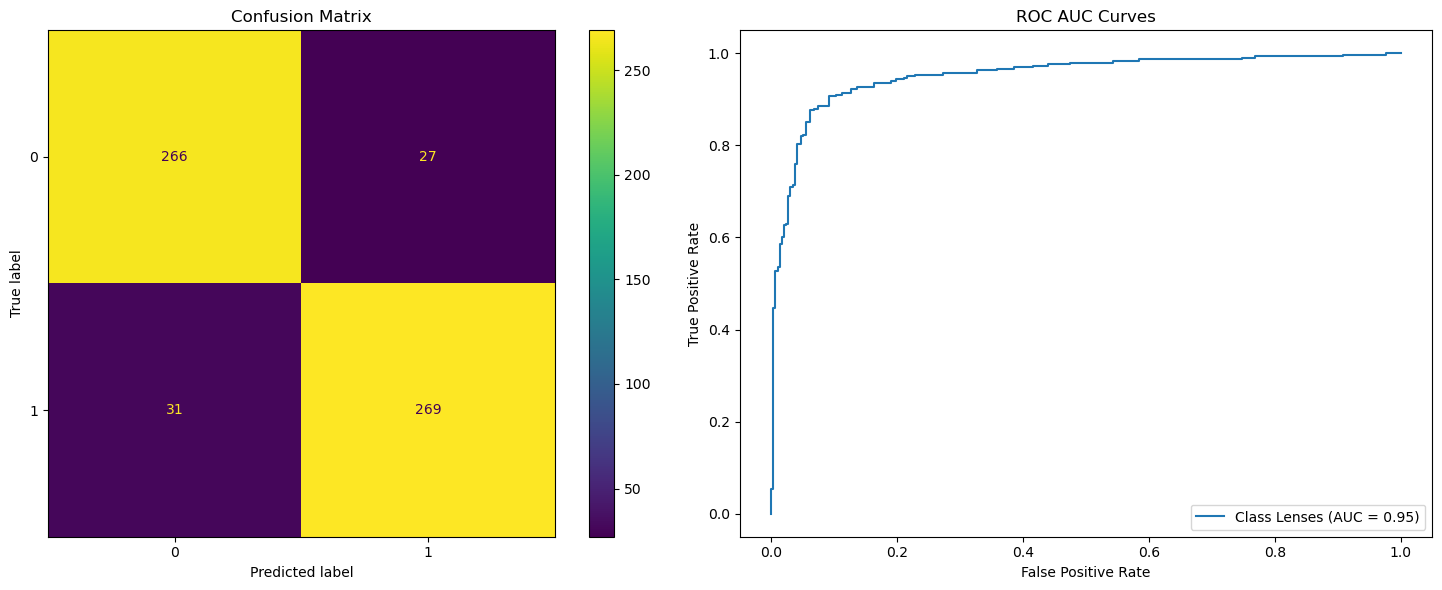

In [34]:
plot_cm_roc(sup3_y_outputs, sup3_y_true)

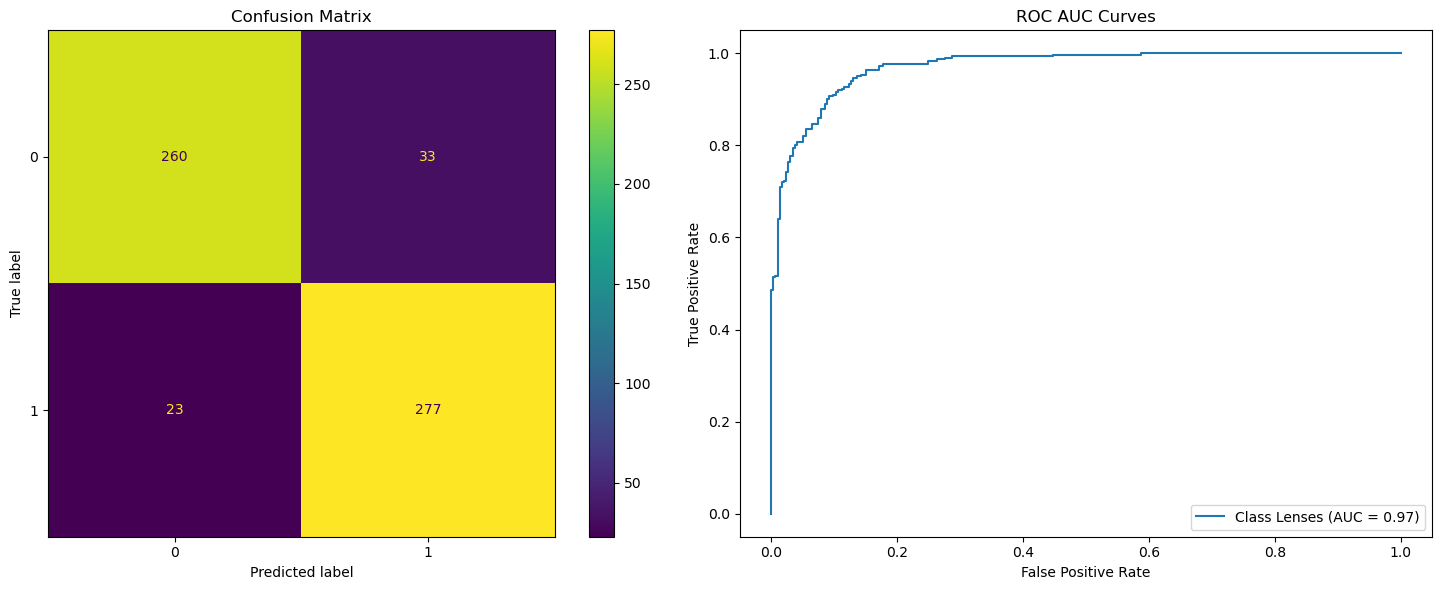

In [35]:
plot_cm_roc(ssl3_y_outputs, ssl3_y_true)

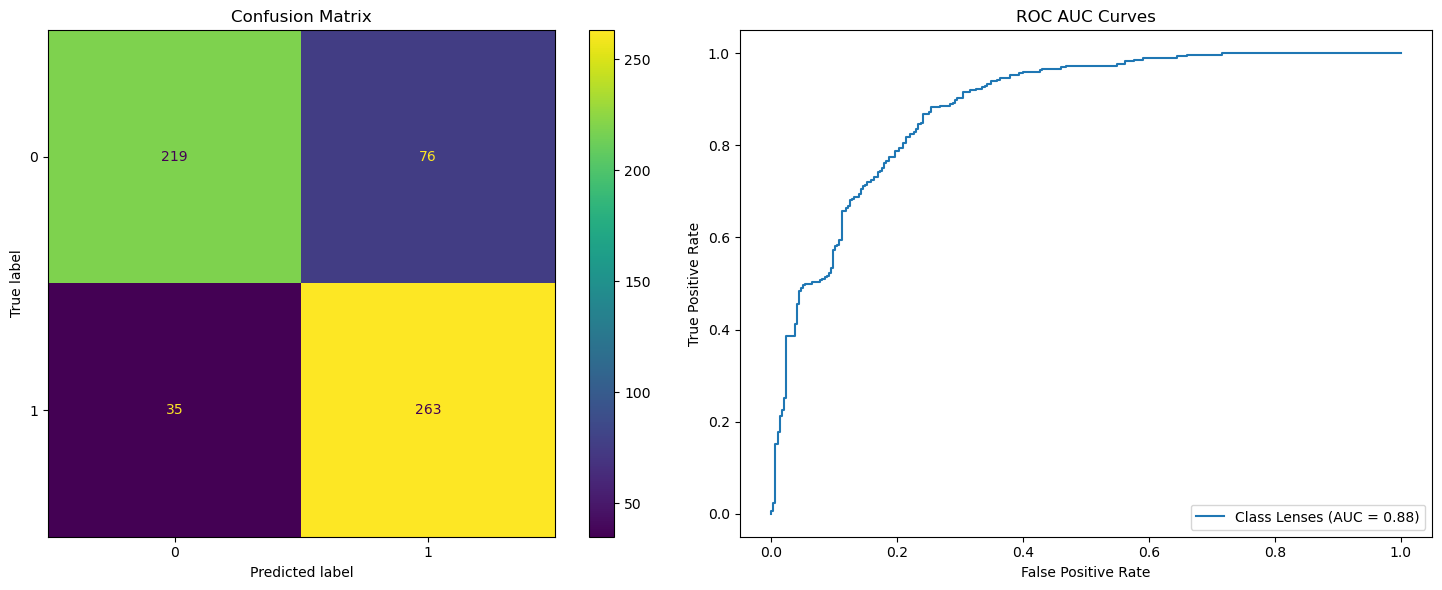

In [36]:
plot_cm_roc(sup1_y_outputs, sup1_y_true)

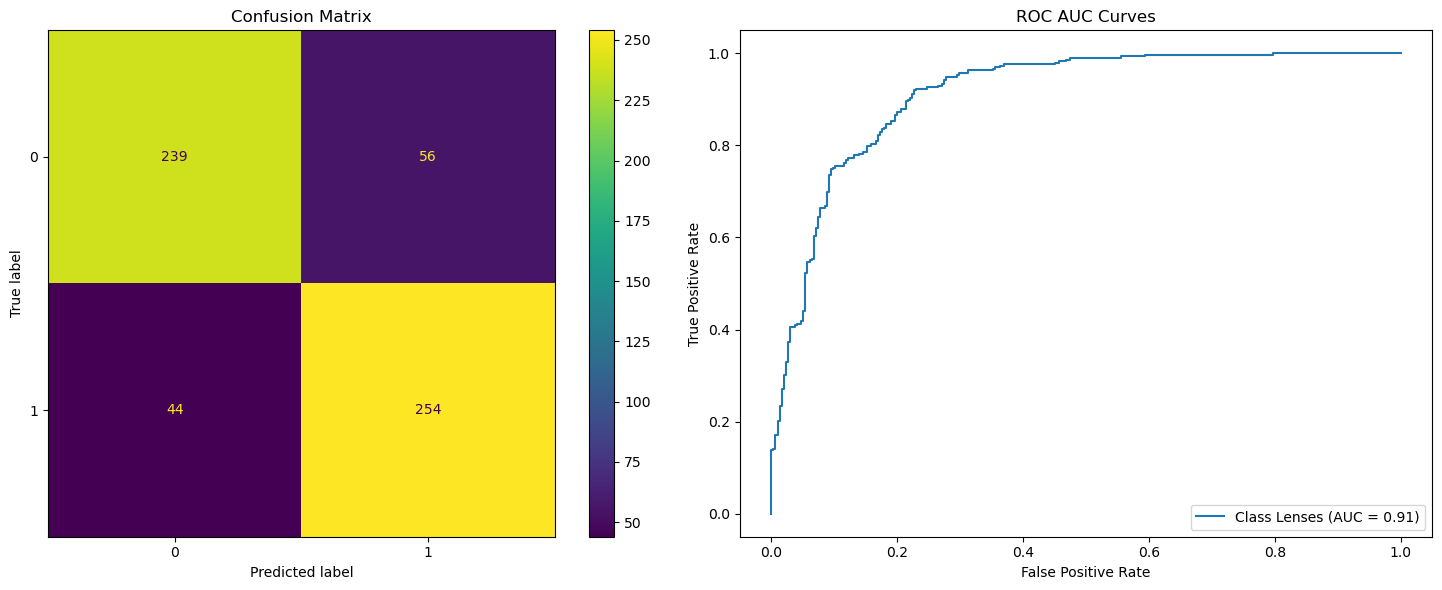

In [37]:
plot_cm_roc(ssl1_y_outputs, ssl1_y_true)